Loading datasets...
Selected sensor: 400001


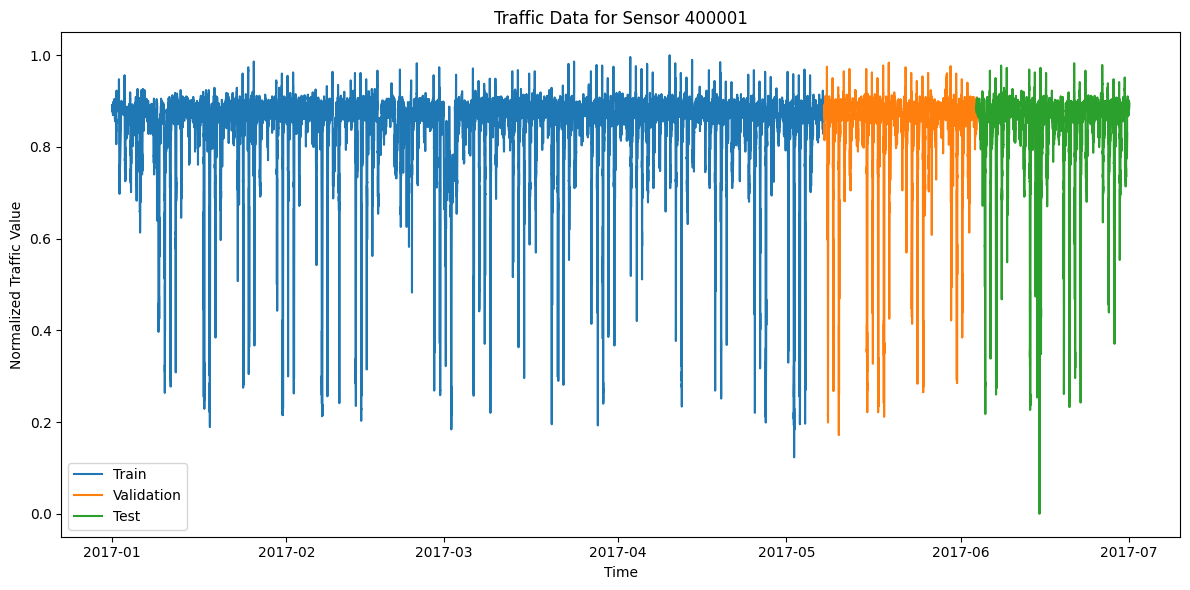

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 1. Load the pre-processed datasets
print("Loading datasets...")
train_df = pd.read_csv("data/processed/train.csv", index_col=0, parse_dates=True)
val_df = pd.read_csv("data/processed/val.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv("data/processed/test.csv", index_col=0, parse_dates=True)

# 2. Select a single sensor for ARIMA modeling (we'll use the first one)
sensor_id = train_df.columns[0]
print(f"Selected sensor: {sensor_id}")

# Extract time series for the selected sensor
train_series = train_df[sensor_id]
val_series = val_df[sensor_id]
test_series = test_df[sensor_id]

# 3. Basic visualization
plt.figure(figsize=(12, 6))
plt.plot(train_series, label='Train')
plt.plot(val_series, label='Validation')
plt.plot(test_series, label='Test')
plt.title(f'Traffic Data for Sensor {sensor_id}')
plt.xlabel('Time')
plt.ylabel('Normalized Traffic Value')
plt.legend()
plt.tight_layout()
plt.savefig('traffic_timeseries.png')
plt.show()
plt.close()

# Uncomment to run multivariate analysis
# print("\nBuilding ARIMA models for multiple sensors...")
# multi_results = build_multivariate_arima(train_df, val_df, test_df, top_n=3)

In [2]:

# 4. Check stationarity with Augmented Dickey-Fuller test
def check_stationarity(series):
    """Check if time series is stationary using ADF test"""
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    is_stationary = result[1] < 0.05
    print(f'Is Stationary: {is_stationary}')
    return is_stationary

print("\nChecking stationarity...")
is_stationary = check_stationarity(train_series)


Checking stationarity...
ADF Statistic: -24.8248
p-value: 0.0000
Is Stationary: True


In [3]:

# 5. If not stationary, difference the series (simple way to make stationary)
diff_order = 0
train_stationary = train_series.copy()

if not is_stationary:
    print("Series is not stationary. Applying differencing...")
    train_stationary = train_series.diff().dropna()
    diff_order = 1
    is_stationary = check_stationarity(train_stationary)
    
    # Try second differencing if still not stationary
    if not is_stationary:
        print("Applying second differencing...")
        train_stationary = train_stationary.diff().dropna()
        diff_order = 2
        is_stationary = check_stationarity(train_stationary)

In [4]:

# 6. Grid search for best ARIMA parameters
def evaluate_arima(p, d, q, train, test):
    """Fit ARIMA model and evaluate on test data"""
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        # Make forecasts
        forecast = model_fit.forecast(steps=len(test))
        
        # Calculate error metrics
        mse = mean_squared_error(test, forecast)
        mae = mean_absolute_error(test, forecast)
        return mse, mae, model_fit
    except:
        return float('inf'), float('inf'), None

print("\nPerforming ARIMA grid search...")
best_mse = float('inf')
best_params = None
best_model = None

# Grid search parameters (simplified to speed up execution)
p_values = range(0, 3)
q_values = range(0, 3)
d = diff_order  # Use the differencing determined earlier

for p in p_values:
    for q in q_values:
        mse, mae, model = evaluate_arima(p, d, q, train_series, val_series)
        if mse < best_mse:
            best_mse = mse
            best_params = (p, d, q)
            best_model = model
            print(f"New best ARIMA{best_params}: MSE={best_mse:.6f}, MAE={mae:.6f}")




Performing ARIMA grid search...
New best ARIMA(0, 0, 0): MSE=0.011408, MAE=0.061205
New best ARIMA(0, 0, 2): MSE=0.011408, MAE=0.061206



Predicting on validation data...


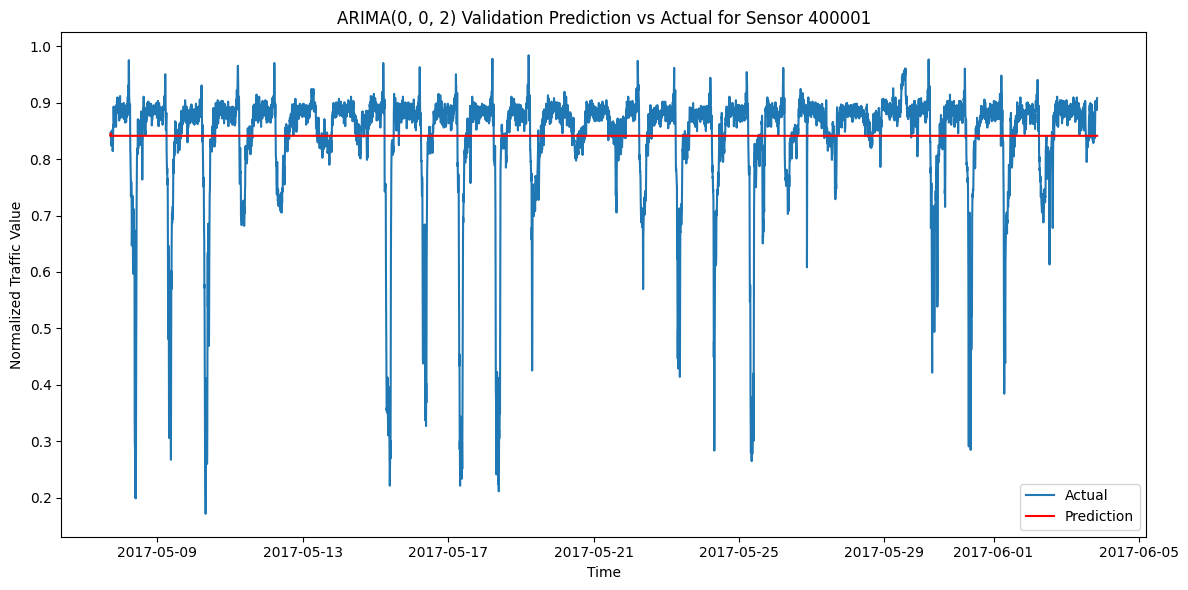


Validation set evaluation:
MSE: 0.011408
RMSE: 0.106808
MAE: 0.061206


In [5]:
# Add after the grid search section (cell 4)

# Predict on validation data using the best model
print("\nPredicting on validation data...")
val_predictions = best_model.forecast(steps=len(val_series))

# Plot the validation predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(val_series.index, val_series, label='Actual')
plt.plot(val_series.index, val_predictions, label='Prediction', color='red')
plt.title(f'ARIMA{best_params} Validation Prediction vs Actual for Sensor {sensor_id}')
plt.xlabel('Time')
plt.ylabel('Normalized Traffic Value')
plt.legend()
plt.tight_layout()
plt.savefig('arima_validation_prediction.png')
plt.show()

# Calculate validation metrics
val_mse = mean_squared_error(val_series, val_predictions)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(val_series, val_predictions)

print(f"\nValidation set evaluation:")
print(f"MSE: {val_mse:.6f}")
print(f"RMSE: {val_rmse:.6f}")
print(f"MAE: {val_mae:.6f}")

In [6]:
import os
import pickle

# 7. Train final model with best parameters
print(f"\nTraining final ARIMA{best_params} model...")
final_model = ARIMA(pd.concat([train_series, val_series]), order=best_params)
final_model_fit = final_model.fit()

# 8. Generate forecasts for test set
forecast_steps = len(test_series)
forecasts = final_model_fit.forecast(steps=forecast_steps)

# 9. Evaluate on test set
test_mse = mean_squared_error(test_series, forecasts)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_series, forecasts)

print(f"\nTest set evaluation:")
print(f"MSE: {test_mse:.6f}")
print(f"RMSE: {test_rmse:.6f}")
print(f"MAE: {test_mae:.6f}")

# Create model directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the final model
model_filename = f'models/arima/arima_{best_params[0]}_{best_params[1]}_{best_params[2]}_{sensor_id}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model_fit, f)
print(f"Model saved to {model_filename}")

# Function to load model (for future use)
def load_arima_model(filename):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    return model


Training final ARIMA(0, 0, 2) model...

Test set evaluation:
MSE: 0.009825
RMSE: 0.099123
MAE: 0.059354
Model saved to models/arima/arima_0_0_2_400001.pkl


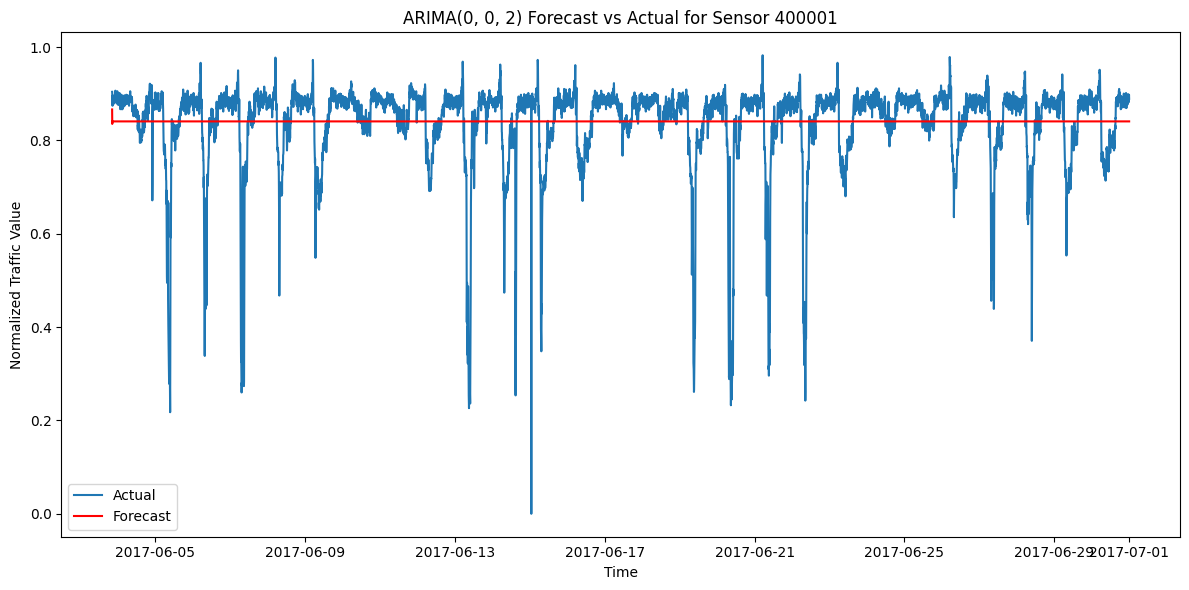


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                 400001   No. Observations:                44298
Model:                 ARIMA(0, 0, 2)   Log Likelihood               81793.338
Date:                Mon, 05 May 2025   AIC                        -163578.676
Time:                        15:54:40   BIC                        -163543.881
Sample:                             0   HQIC                       -163567.715
                              - 44298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8409      0.001    962.601      0.000       0.839       0.843
ma.L1          1.3526      0.002    711.760      0.000       1.349       1.356
ma.L2          0.7397      0.002    

In [7]:

# 10. Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Actual')
plt.plot(test_series.index, forecasts, label='Forecast', color='red')
plt.title(f'ARIMA{best_params} Forecast vs Actual for Sensor {sensor_id}')
plt.xlabel('Time')
plt.ylabel('Normalized Traffic Value')
plt.legend()
plt.tight_layout()
plt.savefig('arima_forecast.png')
plt.show()

# 11. Model diagnostics
print("\nModel Summary:")
print(final_model_fit.summary())

In [8]:
# 12. Multi-step forecast
print("\nGenerating 24-step forecast beyond test data...")
future_forecast = final_model_fit.forecast(steps=24)
print(future_forecast)


Generating 24-step forecast beyond test data...
44298    0.866452
44299    0.835452
44300    0.840860
44301    0.840860
44302    0.840860
44303    0.840860
44304    0.840860
44305    0.840860
44306    0.840860
44307    0.840860
44308    0.840860
44309    0.840860
44310    0.840860
44311    0.840860
44312    0.840860
44313    0.840860
44314    0.840860
44315    0.840860
44316    0.840860
44317    0.840860
44318    0.840860
44319    0.840860
44320    0.840860
44321    0.840860
Name: predicted_mean, dtype: float64


In [9]:
# Modify the build_multivariate_arima function in cell 6

def build_multivariate_arima(train_df, val_df, test_df, top_n=5):
    """Build ARIMA models for multiple sensors"""
    results = {}
    
    # Create model directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Only use top_n sensors to speed up execution
    sensors = train_df.columns[:top_n]
    
    for sensor in sensors:
        print(f"\nProcessing sensor: {sensor}")
        train_series = train_df[sensor]
        val_series = val_df[sensor]
        test_series = test_df[sensor]
        
        # Find best model
        best_mse = float('inf')
        best_params = None
        
        for p in range(0, 2):  # Simplified grid search
            for q in range(0, 2):
                mse, mae, model = evaluate_arima(p, 0, q, train_series, val_series)
                if mse < best_mse:
                    best_mse = mse
                    best_params = (p, 0, q)
        
        # Train final model
        final_model = ARIMA(pd.concat([train_series, val_series]), order=best_params)
        final_model_fit = final_model.fit()
        
        # Generate forecasts
        forecasts = final_model_fit.forecast(steps=len(test_series))
        
        # Calculate metrics
        test_mse = mean_squared_error(test_series, forecasts)
        test_rmse = np.sqrt(test_mse)
        
        # Save model
        model_filename = f'models/arima/arima_{best_params[0]}_{best_params[1]}_{best_params[2]}_{sensor}.pkl'
        with open(model_filename, 'wb') as f:
            pickle.dump(final_model_fit, f)
        
        results[sensor] = {
            'params': best_params,
            'mse': test_mse,
            'rmse': test_rmse,
            'model_path': model_filename
        }
        
        print(f"  Best model: ARIMA{best_params}, RMSE: {test_rmse:.6f}")
        print(f"  Model saved to {model_filename}")
        
        # Plot validation predictions
        val_preds = final_model_fit.forecast(steps=len(val_series))
        plt.figure(figsize=(10, 5))
        plt.plot(val_series.index, val_series, label='Actual')
        plt.plot(val_series.index, val_preds, label='Prediction', color='red')
        plt.title(f'ARIMA{best_params} Validation Prediction for Sensor {sensor}')
        plt.xlabel('Time')
        plt.ylabel('Normalized Traffic Value')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'arima_validation_{sensor}.png')
        plt.close()
    
    return results

In [10]:
print("\nBuilding ARIMA models for multiple sensors...")
multi_results = build_multivariate_arima(train_df, val_df, test_df, top_n=3)


Building ARIMA models for multiple sensors...

Processing sensor: 400001
  Best model: ARIMA(0, 0, 0), RMSE: 0.099124
  Model saved to models/arima/arima_0_0_0_400001.pkl

Processing sensor: 400017
  Best model: ARIMA(1, 0, 1), RMSE: 0.225825
  Model saved to models/arima/arima_1_0_1_400017.pkl

Processing sensor: 400030
  Best model: ARIMA(1, 0, 0), RMSE: 0.147434
  Model saved to models/arima/arima_1_0_0_400030.pkl



Performing seasonal decomposition (period=24)...


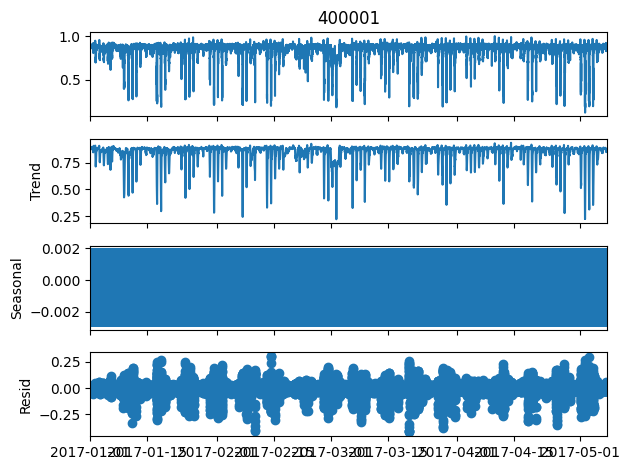

In [11]:

# 7. Seasonal decomposition to inspect seasonality visually
from statsmodels.tsa.seasonal import seasonal_decompose

print("\nPerforming seasonal decomposition (period=24)...")
decomposition = seasonal_decompose(train_series, model='additive', period=24)
decomposition.plot()
plt.tight_layout()
plt.savefig('seasonal_decomposition.png')
plt.show()


In [ ]:

# 8. SARIMA grid search
from statsmodels.tsa.statespace.sarimax import SARIMAX

def evaluate_sarima(p, d, q, P, D, Q, s, train, test):
    """Fit SARIMA model and evaluate on test data"""
    try:
        model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)
        mae = mean_absolute_error(test, forecast)
        return mse, mae, model_fit
    except:
        return float('inf'), float('inf'), None

print("\nPerforming SARIMA grid search...")
best_sarima_mse = float('inf')
best_sarima_model = None
best_sarima_params = None

# Define SARIMA grid
s = 24
for p in range(0, 2):
    for q in range(0, 2):
        for P in range(0, 2):
            for Q in range(0, 2):
                mse, mae, model = evaluate_sarima(p, diff_order, q, P, 1, Q, s, train_series, val_series)
                if mse < best_sarima_mse:
                    best_sarima_mse = mse
                    best_sarima_model = model
                    best_sarima_params = (p, diff_order, q, P, 1, Q, s)
                    print(f"New best SARIMA({p},{diff_order},{q})x({P},1,{Q},{s}): MSE={mse:.6f}, MAE={mae:.6f}")



Performing SARIMA grid search...
New best SARIMA(0,0,0)x(0,1,0,24): MSE=0.012006, MAE=0.056745
New best SARIMA(0,0,0)x(0,1,1,24): MSE=0.011675, MAE=0.055371
New best SARIMA(0,0,0)x(1,1,1,24): MSE=0.011413, MAE=0.061227
New best SARIMA(1,0,0)x(0,1,1,24): MSE=0.011402, MAE=0.061463


In [ ]:

# 9. Forecasting with best SARIMA model
print("\nForecasting on validation set with best SARIMA model...")
sarima_val_forecast = best_sarima_model.forecast(steps=len(val_series))

plt.figure(figsize=(12, 6))
plt.plot(val_series.index, val_series, label='Actual')
plt.plot(val_series.index, sarima_val_forecast, label='SARIMA Prediction', color='orange')
plt.title(f'SARIMA{best_sarima_params} Validation Prediction vs Actual for Sensor {sensor_id}')
plt.xlabel('Time')
plt.ylabel('Normalized Traffic Value')
plt.legend()
plt.tight_layout()
plt.savefig('sarima_validation_prediction.png')
plt.show()

val_mse = mean_squared_error(val_series, sarima_val_forecast)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(val_series, sarima_val_forecast)

print(f"\nSARIMA Validation set evaluation:")
print(f"MSE: {val_mse:.6f}")
print(f"RMSE: {val_rmse:.6f}")
print(f"MAE: {val_mae:.6f}")
